In [2]:
"""
Importing Libraries
"""

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch.optim as optim

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

2022-05-24 19:54:58 prophet.plot ERROR: Importing plotly failed. Interactive plots will not work.
/Users/s1b0ert/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/s1b0ert/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/s1b0ert/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64

In [37]:
"""
Configuration
"""

# forecast periods
FC_N = 36               
FC_STRIDE = 10
# period at which to split training and validation dataset
FC_START = "19590101"   
EPOCH = 10   

In [55]:

"""
Data
"""

ts = AirPassengersDataset().load()

series = ts  
df = ts.pd_dataframe()
print(df.head())
print(df.shape)

component   #Passengers
Month                  
1949-01-01        112.0
1949-02-01        118.0
1949-03-01        132.0
1949-04-01        129.0
1949-05-01        121.0
(144, 1)


In [49]:
print(df.describe())

component  #Passengers
count       144.000000
mean        280.298611
std         119.966317
min         104.000000
25%         180.000000
50%         265.500000
75%         360.500000
max         622.000000


In [56]:
df = df.reset_index()
df

component,Month,#Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0
...,...,...
139,1960-08-01,606.0
140,1960-09-01,508.0
141,1960-10-01,461.0
142,1960-11-01,390.0


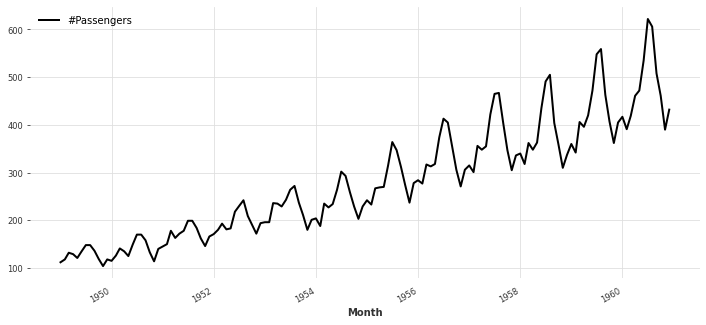

In [9]:
plt.figure(100, figsize=(12,5))
series.plot()

In [10]:
# analyze its seasonality

is_seasonal, periodicity = check_seasonality(ts, max_lag=240)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (months) : 12.0
periodicity (~years) : 1.0


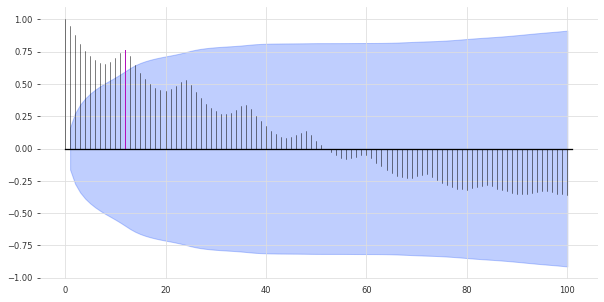

In [12]:
plot_acf(ts, periodicity, max_lag=100)

In [16]:
# split training vs test dataset
train, val = ts.split_after(pd.Timestamp(FC_START))
print(train[0:5])
print(val[0:5])

<TimeSeries (DataArray) (Month: 5, component: 1, sample: 1)>
array([[[112.]],

       [[118.]],

       [[132.]],

       [[129.]],

       [[121.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1949-05-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
<TimeSeries (DataArray) (Month: 5, component: 1, sample: 1)>
array([[[342.]],

       [[406.]],

       [[396.]],

       [[420.]],

       [[472.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1959-02-01 1959-03-01 ... 1959-06-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample


In [21]:
# normalize the time series

trf = Scaler()
# fit the transformer to the training dataset
train_trf = trf.fit_transform(train)
# apply the transformer to the validation set and the complete series 
val_trf = trf.transform(val)
ts_trf = trf.transform(ts)

print(train_trf[0:5])
print(f'********* length of training data {len(train_trf)} **************')
print(val_trf[0:5])
print(f'********* length of training data {len(val_trf)} **************')
print(ts_trf[0:5])

<TimeSeries (DataArray) (Month: 5, component: 1, sample: 1)>
array([[[0.01995012]],

       [[0.03491272]],

       [[0.06982544]],

       [[0.06234414]],

       [[0.04239401]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1949-05-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
********* length of training data 121 **************
<TimeSeries (DataArray) (Month: 5, component: 1, sample: 1)>
array([[[0.59351621]],

       [[0.75311721]],

       [[0.72817955]],

       [[0.78802993]],

       [[0.91770574]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1959-02-01 1959-03-01 ... 1959-06-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
********* length of training data 23 **************
<TimeSeries (DataArray) (Month: 5, component: 1, sample: 1)>
array([[[0.01995012]],

       [[0.03491272]],

       [[0.06982544]],

       [[0.06234414]],

       [[0.04239401]]])
Co

In [33]:
# create month and year covariate series

year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), 
        freq=ts.freq_str, 
        periods=1000),
    attribute='year', 
    one_hot=False)
print(year_series[0:5])

year_series = Scaler().fit_transform(year_series)

month_series = datetime_attribute_timeseries(
    year_series, 
    attribute='month', 
    one_hot=True)
print(month_series[0])

covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp(FC_START))
print(cov_train[0:5].pd_dataframe())

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)>
array([[[1949.]],

       [[1949.]],

       [[1949.]],

       [[1949.]],

       [[1949.]]])
Coordinates:
  * time       (time) datetime64[ns] 1949-01-01 1949-02-01 ... 1949-05-01
  * component  (component) object 'year'
Dimensions without coordinates: sample
<TimeSeries (DataArray) (time: 1, component: 12, sample: 1)>
array([[[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]])
Coordinates:
  * time       (time) datetime64[ns] 1949-01-01
  * component  (component) object 'month_1' 'month_2' ... 'month_11' 'month_12'
Dimensions without coordinates: sample
component   year  month_1  month_2  month_3  month_4  month_5  month_6  \
time                                                                     
1949-01-01   0.0      1.0      0.0      0.0      0.0      0.0      0.0   
1949-02-01   0.0      0.0      1.0      0.0  

In [38]:
"""
Model Training
"""

flavor = 'RNN'
model_RNN = RNNModel(
        model=flavor,
        model_name=flavor + str(" RNN"),
        input_chunk_length=periodicity,
        training_length=20,
        hidden_dim=20,
        batch_size=16,
        n_epochs=EPOCH,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True)

t_start =  time.perf_counter()
print("\nbeginning the training of the {0} RNN:".format(flavor))

res = model_RNN.fit(train_trf,
                    future_covariates=cov_train,
                    val_series=val_trf,
                    val_future_covariates=cov_val,
                    verbose=True)

res_time = time.perf_counter() - t_start
print("training of the {0} RNN has completed:".format(flavor), f'{res_time:.2f} sec')


beginning the training of the RNN RNN:


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

training of the RNN RNN has completed: 18.80 sec


In [59]:
"""
Prediction on Sample
"""

# sample = covariates[0:12]
# print(sample.pd_dataframe())
pred = model_RNN.predict(n=3, future_covariates=covariates)
pred.pd_dataframe()

Predicting: 7it [00:00, ?it/s]

component,#Passengers
Month,
1959-02-01,0.377860
1959-03-01,0.430595
1959-04-01,0.407298
